**Giorgio Mendoza**

**RBE595-S24-S04**

**DP Programming Excercise**

Description:
The code aims to illustrate how different reinforcement learning algorithms (Policy Iteration, Generalized Policy Iteration, Value Iteration) can be applied to find optimal navigation strategies in a grid world. It also demonstrates both deterministic and stochastic behaviors, showcasing how the agent's decision-making changes under uncertainty.

The agent can start from any free space within the grid world. Free spaces are represented by cells in the WorldGrid that have a value of 0.

The goal location is specified by the desired_position variable, which is initialized in the main execution part of the code. In this specific implementation, the goal is set at the coordinates (7, 10)

Objective:
The agent's objective is to find the most efficient path to the goal while avoiding obstacles. This is achieved by learning an optimal policy through different reinforcement learning algorithms.

The learned policy guides the agent on which action to take in each state (position in the grid) to maximize its cumulative reward, which involves successfully reaching the goal and minimizing collisions with obstacles.

In [192]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

reward_obstacle_collision_init = -50
reward_desired_goal_init = 100
tolerance_init = 1
mode_init = True
actions_init = 8
discount_factor_init = 0.95
reward_clear_move_init = -1.0
desired_position_init = (7,10)

class Agent:
    def __init__(self, WorldGrid, total_actions = actions_init, discount_factor = discount_factor_init, desired_position = desired_position_init, reward_clear_move = reward_clear_move_init,
                    reward_obstacle_collision = reward_obstacle_collision_init, reward_desired_goal = reward_desired_goal_init, tolerance = tolerance_init, mode = mode_init):
        self.total_actions = total_actions  # total number of actions
        self.discount_factor = discount_factor  # discount factor for future rewards
        self.desired_position = desired_position  # location of the goal
        self.reward_clear_move = reward_clear_move  # reward for a clear move
        self.reward_desired_goal = reward_desired_goal  # reward for reaching the goal
        self.reward_obstacle_collision = reward_obstacle_collision  # penalty for hitting an obstacle
        self.tolerance = tolerance  # convergence threshold
        self.deterministic = mode  # flag for deterministic or stochastic model
        self.WorldGrid = WorldGrid  # world definition
        self.widthGrid, self.heightGrid = self.WorldGrid.shape  # dimensions of the world
        # filter out boundary and obstacle states
        self.states = [state for state in product(range(self.widthGrid), range(self.heightGrid)) if self.WorldGrid[state] == 0]
        self.valid_states = len(self.states)  # total number of valid states
        print("Total number of valid states:", self.valid_states)

        # define movement actions and their state transitions
        self.valid_movement_states = {
            "up": (-1, 0),
            "down": (1, 0),
            "right": (0, 1),
            "left": (0, -1),
            "up_right": (-1, 1),
            "up_left": (-1, -1),
            "down_right": (1, 1),
            "down_left": (1, -1)
        }
        # define actions with their probabilities
        if self.deterministic:
            self.valid_actions = {key: [(key, 1)] for key in self.valid_movement_states}
        else:
            # stochastic model with 60% intended move, 20% each for adjacent moves
            self.valid_actions = {
                "up": [("up", 0.6), ("up_left", 0.2), ("up_right", 0.2)],
                "up_left": [("up_left", 0.6), ("up", 0.2), ("left", 0.2)],
                "up_right": [("up_right", 0.6), ("up", 0.2), ("right", 0.2)],
                "down": [("down", 0.6), ("down_left", 0.2), ("down_right", 0.2)],
                "down_left": [("down_left", 0.6), ("down", 0.2), ("left", 0.2)],
                "down_right": [("down_right", 0.6), ("down", 0.2), ("right", 0.2)],
                "left": [("left", 0.6), ("up_left", 0.2), ("down_left", 0.2)],
                "right": [("right", 0.6), ("up_right", 0.2), ("down_right", 0.2)]
            }

        # function for summing state and action tuples
        self.state_plus_action = lambda state, action: tuple(map(sum, zip(state, self.valid_movement_states[action])))

        # initialize policy with equal probability for each action
        self.init_policy = {state: {action: 1 / self.total_actions for action in self.valid_actions} for state in self.states}
        self.init_value_function = np.zeros_like(self.WorldGrid)

    def PolicyGraph(self, policy, string):
        fig, ax = plt.subplots(figsize=(15, 8))  # Create figure and axes
        ax.set_title(string)
        goal_y_coordinate, goal_x_coordinate = self.desired_position
        plt.plot(goal_x_coordinate + 0.5, goal_y_coordinate + 0.5, "ro", markersize=10)  # mark the goal with a red dot

        # Draw grid lines
        for i in range(self.WorldGrid.shape[0] + 1):
            ax.axhline(i, lw=1, color='black', zorder=5)
        for i in range(self.WorldGrid.shape[1] + 1):
            ax.axvline(i, lw=1, color='black', zorder=5)

        # Draw walls (obstacles)
        for y in range(self.WorldGrid.shape[0]):
            for x in range(self.WorldGrid.shape[1]):
                if self.WorldGrid[y, x] == 1:
                    ax.add_patch(plt.Rectangle((x, self.WorldGrid.shape[0] - y - 1), 1, 1, fill=True, color='black', zorder=5))

        # Add policy arrows
        for state in policy:
            if 1 in policy[state].values():
                y, x = state
                action = max(policy[state], key=policy[state].get)
                dy, dx = self.valid_movement_states[action]
                ax.arrow(x + 0.5, self.WorldGrid.shape[0] - y - 0.5, dx * 0.3, -dy * 0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue', zorder=5)


        # Set axis limits and remove labels
        ax.set_xlim(0, self.WorldGrid.shape[1])
        ax.set_ylim(0, self.WorldGrid.shape[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.invert_yaxis()  # Invert y-axis to match the matrix representation

        plt.show()


    def ValueGraph(self, value, string):
        plt.figure(figsize=(8, 8))  # larger figure size for clarity
        plt.title(string)
        goal_y_coordinate, goal_x_coordinate = self.desired_position
        plt.plot(goal_x_coordinate, goal_y_coordinate, "ro", markersize=10)  # mark the goal with a red dot
        im = plt.imshow(value, cmap="hot", interpolation='none')  # 'hot' colormap for value representation

        # add a colorbar to indicate value scale
        plt.colorbar(im)
        plt.show()

    def PolicyEval(self, policy, value_function):
      max_change = 0
      for state in self.states:
          # initialize the value for this state
          val = 0

          # loop over all actions and their probabilities
          for action, action_probs in self.valid_actions.items():
              pi = policy[state][action]

              # sum the value for all possible outcomes of this action
              for _a, prob in action_probs:
                  next_state = self.state_plus_action(state, _a)

                  # if next state is valid (not out of bounds or an obstacle)
                  if next_state in self.states:
                      SetReward = self.SetReward(next_state)
                      val += pi * prob * (SetReward + self.discount_factor * value_function[next_state])

          # update the maximum max_change and value function for this state
          max_change = max(max_change, abs(val - value_function[state]))
          value_function[state] = val

      return value_function, max_change

    def PolicyImprov(self, policy, value):
        is_converged = True
        # iterate over all states to improve policy
        for state in self.states:
            # find the best action according to the current value function
            best_action_value = float('-inf')
            best_action = None

            # examine the value of each action
            for action in self.valid_actions:
                action_value = 0
                # consider the outcome of each action
                for _a, prob in self.valid_actions[action]:
                    next_state = self.state_plus_action(state, _a)
                    # calculate value if next state is valid
                    if next_state in self.states:
                        SetReward = self.SetReward(next_state)
                        action_value += prob * (SetReward + self.discount_factor * value[next_state])

                # update the best action if this action is better
                if action_value > best_action_value:
                    best_action_value = action_value
                    best_action = action

            # compare the best action with the current policy's action
            current_policy_action = max(policy[state], key=policy[state].get, default=None)
            if current_policy_action != best_action:
                is_converged = False

            # update the policy for this state
            for action in self.valid_actions:
                policy[state][action] = 1 if action == best_action else 0

        return policy, value, is_converged

    def PolicyIter(self):
        # initialize policy and value function
        policy = dict(self.init_policy)
        value = np.array(self.init_value_function)

        # loop for policy iteration
        while True:
            # policy evaluation - only needs to run until max_change < tolerance once per iteration
            value, max_change = self.PolicyEval(policy, value)
            while max_change >= self.tolerance:
                value, max_change = self.PolicyEval(policy, value)

            # policy improvement step
            policy, value, is_converged = self.PolicyImprov(policy, value)

            # if policy is stable, we're done
            if is_converged:
                break

        return policy, value

    def GPI(self):
        # initialize policy and value function
        policy = dict(self.init_policy)
        value = np.array(self.init_value_function)

        # run generalized policy iteration
        while True:
            # policy evaluation with a single pass
            value, _ = self.PolicyEval(policy, value)

            # policy improvement step
            policy, value, is_converged = self.PolicyImprov(policy, value)

            # if policy is stable, the iteration stops
            if is_converged:
                break

        return policy, value

    def ValueIter(self, plot=False):
        value = np.array(self.init_value_function)

        # keep iterating until no significant changes are made to the value function
        while True:
            max_change = 0
            for state in self.states:
                # compute the value of each action and select the best one
                best_action_value = float('-inf')
                for action, action_probs in self.valid_actions.items():
                    action_value = sum(
                        prob * (self.SetReward(self.state_plus_action(state, _a)) + self.discount_factor * value[self.state_plus_action(state, _a)])
                        for _a, prob in action_probs if self.state_plus_action(state, _a) in self.states
                    )
                    best_action_value = max(best_action_value, action_value)

                # track the largest change from the current value function
                max_change = max(max_change, abs(best_action_value - value[state]))
                # update the value function with the best action value
                value[state] = best_action_value

            # display the current value function if live plotting is enabled
            if plot:
                self.ValueGraph(value, "Value Iteration Live Value Plot")

            # stop if the change is below the threshold for all states
            if max_change < self.tolerance:
                break

        # construct a policy where each state takes the action leading to the highest value
        policy = {state: {action: 0 for action in self.valid_actions} for state in self.states}
        for state in self.states:
            _, best_action = max(
                ((sum(prob * (self.SetReward(self.state_plus_action(state, _a)) + self.discount_factor * value[self.state_plus_action(state, _a)])
                  for _a, prob in action_probs if self.state_plus_action(state, _a) in self.states), action)
                for action, action_probs in self.valid_actions.items()),
                key=lambda x: x[0]
            )
            policy[state][best_action] = 1

        return policy, value

    def SetReward(self, state):
        # returns the reward for the robot's state after an action
        # hitting an obstacle yields reward_obstacle_collision
        # reaching the goal yields reward_desired_goal
        # any other move yields reward_clear_move

        if state == self.desired_position:
            return self.reward_desired_goal
        elif self.WorldGrid[state] == 1:  # Direct indexing since state is a tuple
            return self.reward_obstacle_collision
        return self.reward_clear_move

if __name__ == "__main__":
    # define the world as a numpy array
    WorldGrid = np.array(
[
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

 # adjust goal coordinates indexing
    # create agent instance
    agent = Agent(WorldGrid, desired_position=(7, 10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total number of valid states: 399


The collective arrows form paths leading towards a common destination. The arrows seem to avoid black squares, adhering to the constraints of the environment. This suggests that the policy has successfully learned to navigate around obstacles.
As shown below, the arrows converge towards the goal state in the direction where most arrows in the free spaces point towards.
Since this is a "Deterministic-Model PI", each state has one clear action to take (one arrow per state), which aligns with a deterministic approach where the outcome of an action is certain.

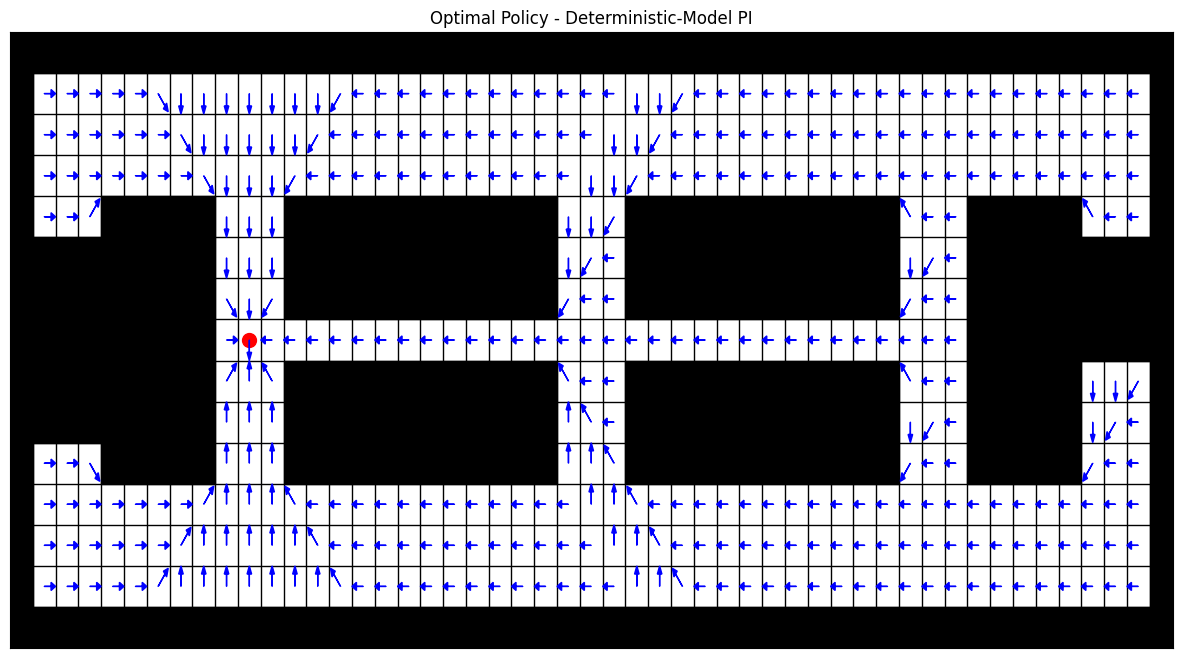

In [193]:
    # perform policy iteration for deterministic model
    policy, value = agent.PolicyIter()
    agent.PolicyGraph(policy, "Optimal Policy - Deterministic-Model PI")


This plot visualizes the value function for the deterministic model using policy iteration. The color gradient, ranging from yellow to dark red, represents the value at each state in the grid, with higher values in yellow and lower values in dark red. The filled red circle indicates the goal position, which is the state with the highest value—this is consistent with the idea that reaching the goal yields the highest reward.

Black squares represent obstacles or walls where the agent cannot go. The intensity of the colors reflects the potential value of being in a particular state; states closer to the goal tend to have higher values since they are closer to achieving the reward. This value function helps to guide the agent's decisions: at each state, the agent will choose the action that leads to the state with the highest value.

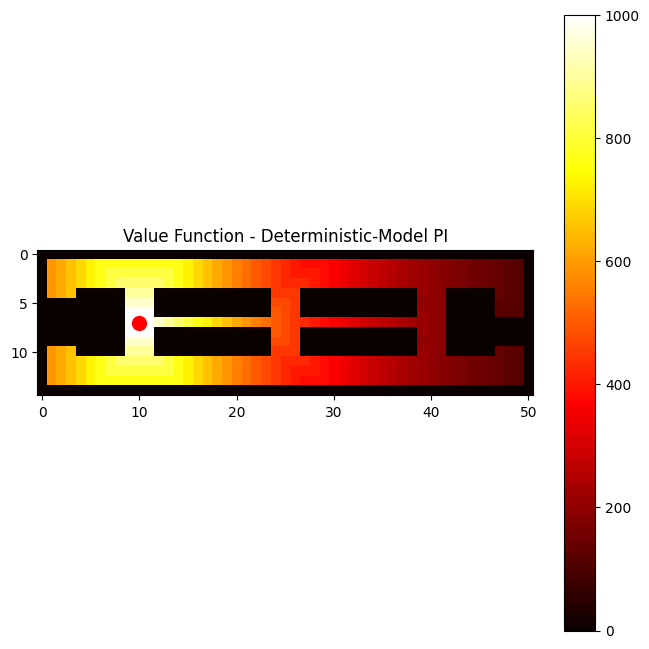

In [194]:
    agent.ValueGraph(value, "Value Function - Deterministic-Model PI")

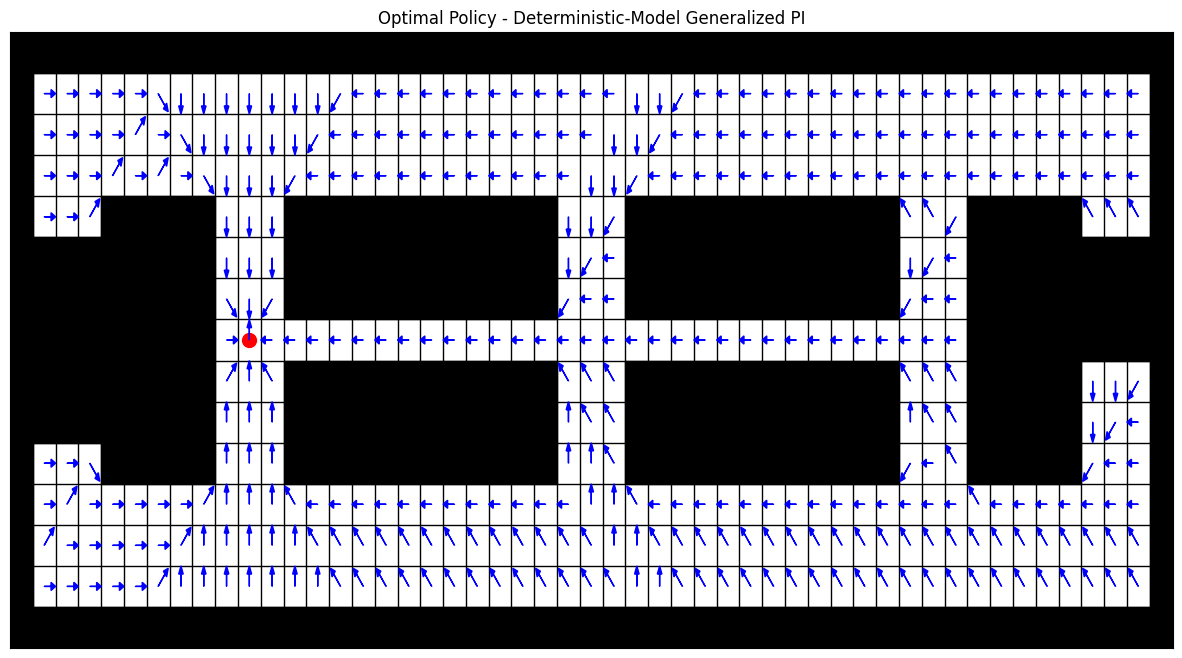

In [195]:
    # perform generalized policy iteration for deterministic model
    policy, value = agent.GPI()
    agent.PolicyGraph(policy, "Optimal Policy - Deterministic-Model Generalized PI")

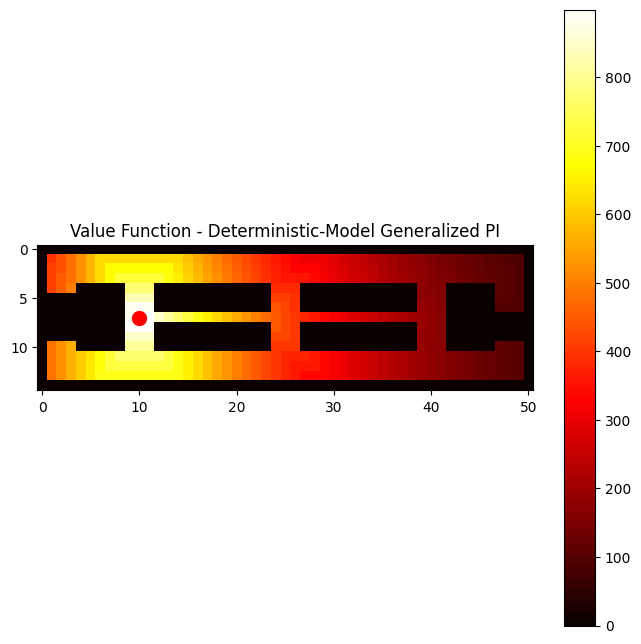

In [196]:
    agent.ValueGraph(value, "Value Function - Deterministic-Model Generalized PI")

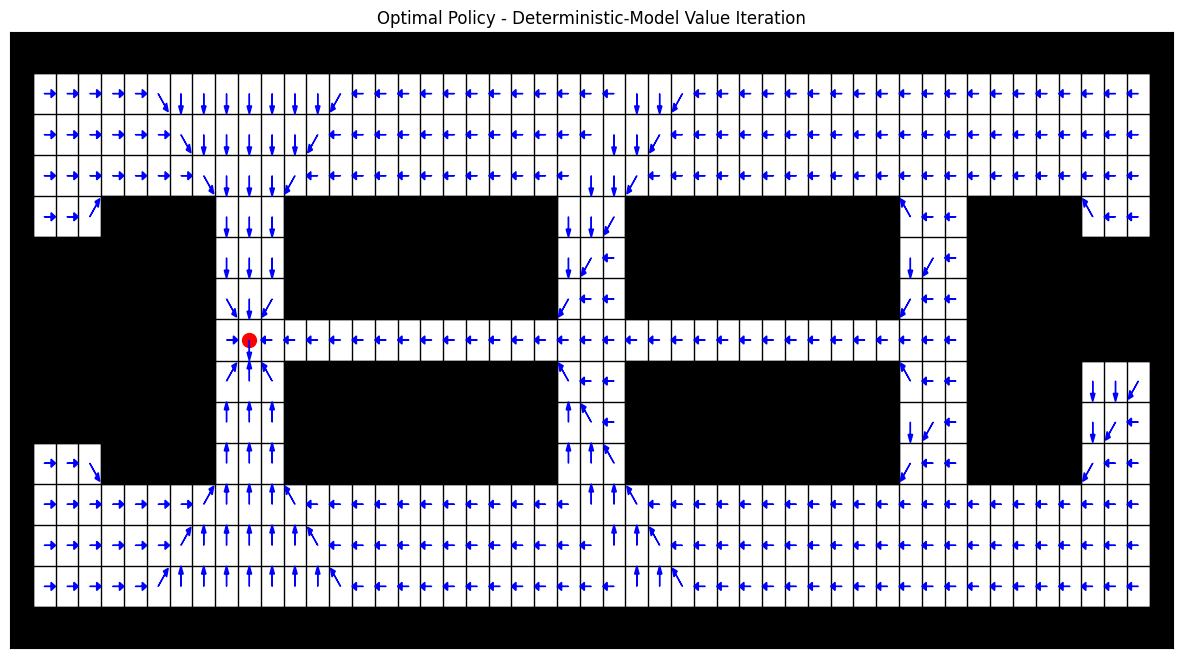

In [197]:
    # perform value iteration for deterministic model
    policy, value = agent.ValueIter()
    agent.PolicyGraph(policy, "Optimal Policy - Deterministic-Model Value Iteration")

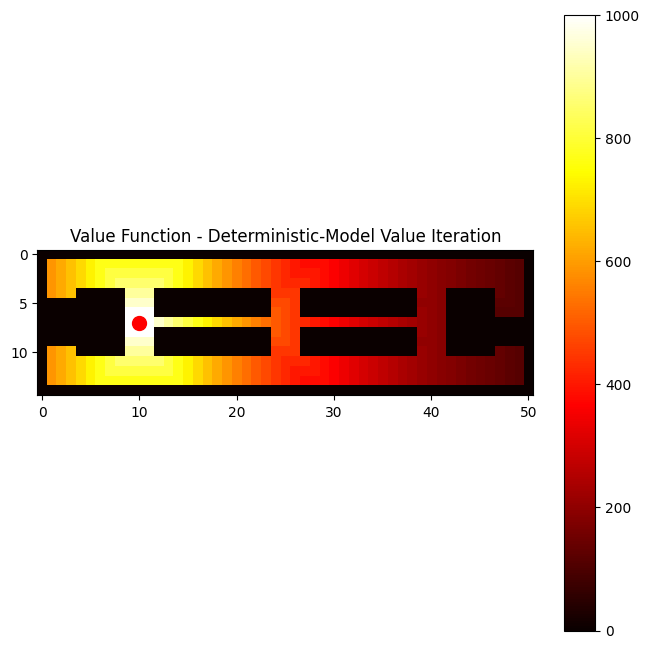

In [198]:
    agent.ValueGraph(value, "Value Function - Deterministic-Model Value Iteration")

The plot represents a policy for navigating through a grid world environment in a stochastic setting using policy iteration. Again, arrows indicate the direction of the policy for each state: where the agent should move from that state considering the uncertainty of the movement (due to the stochastic nature of the model).

The spread of the arrows around the intended direction suggests that the policy accounts for the probability of the agent not moving exactly as intended but potentially veering off to the adjacent directions, reflecting the stochastic nature of the environment.

The policy guides the agent towards the goal while accounting for uncertainties in movement, providing the best action to take from each state to maximize the chances of reaching the goal state.

Total number of valid states: 399


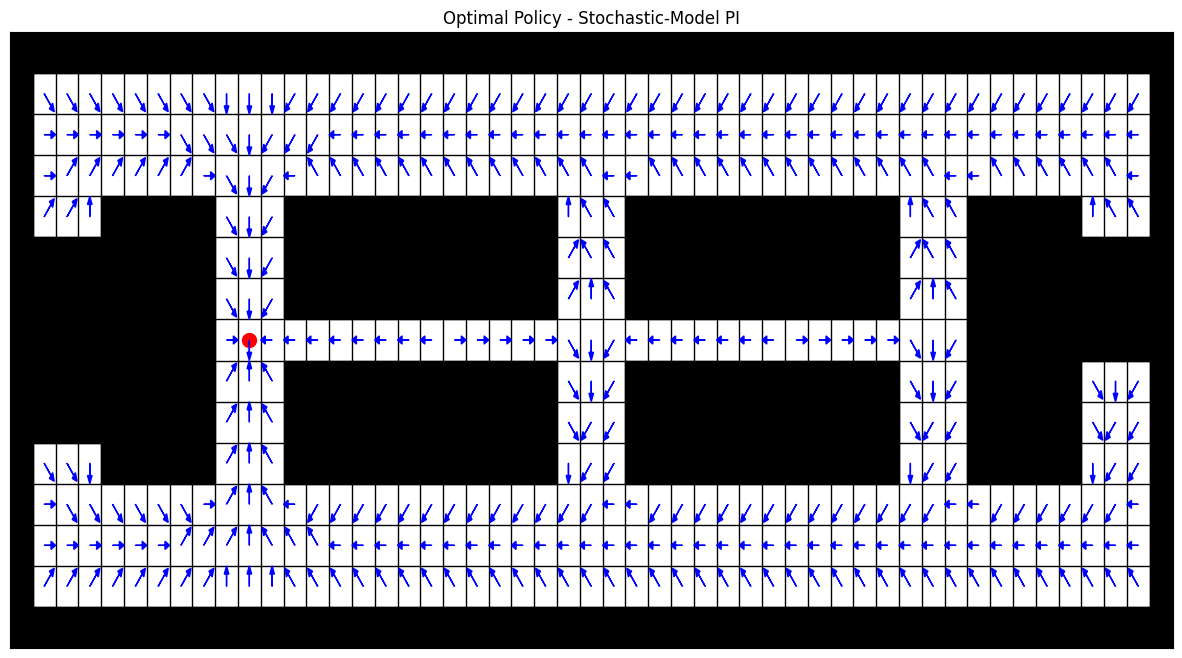

In [199]:
# create a agent instance with a stochastic model
agent = Agent(WorldGrid, desired_position=(7, 10), mode=False)

# perform policy iteration for the stochastic model
policy, value = agent.PolicyIter()
agent.PolicyGraph(policy, "Optimal Policy - Stochastic-Model PI")

This plot illustrates the value function for a stochastic model, as determined by policy iteration. The value function assigns a numerical value to each state in the grid, representing the long-term reward expected from that state under the optimal policy. Similarly, the color gradient from yellow to red indicates the range of these values, with brighter colors representing higher values.

The red dot marks the goal state and has the highest value because reaching the goal is associated with the highest reward. Darker areas, corresponding to lower values, indicate less optimal states that either lead away from the goal or are close to obstacles, represented by the black areas. The obstacles themselves have no value since they are non-traversable states.

This value function is important in stochastic environments because it captures the expected utility of states while accounting for the uncertainty and risk of not moving as intended. In essence, it guides the agent's decision-making process by providing a landscape of expected returns, helping the agent to choose actions that maximize the cumulative reward over time.

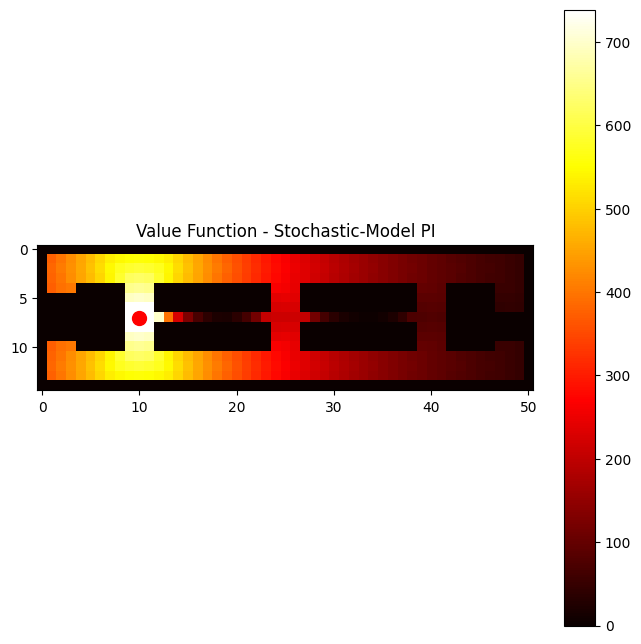

In [200]:
agent.ValueGraph(value, "Value Function - Stochastic-Model PI")

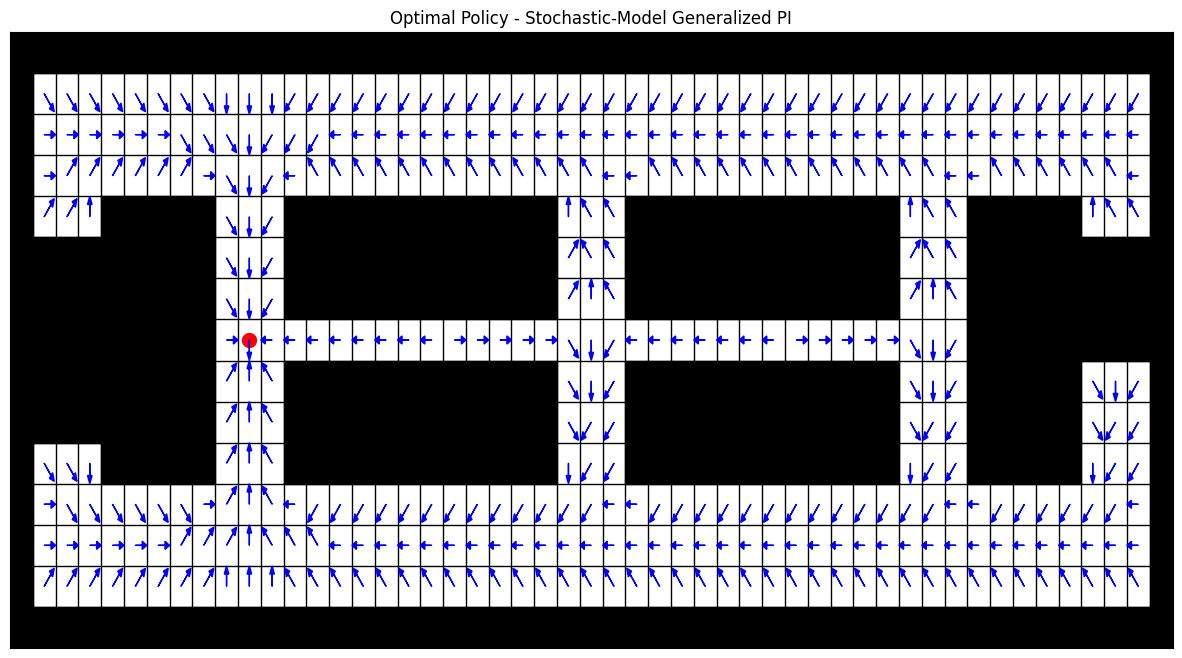

In [201]:
# perform generalized policy iteration for the stochastic model
policy, value = agent.GPI()
agent.PolicyGraph(policy, "Optimal Policy - Stochastic-Model Generalized PI")

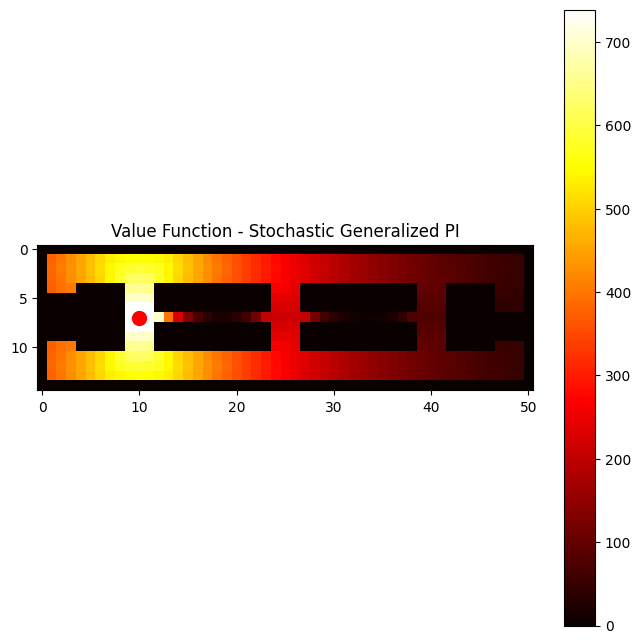

In [202]:
agent.ValueGraph(value, "Value Function - Stochastic Generalized PI")

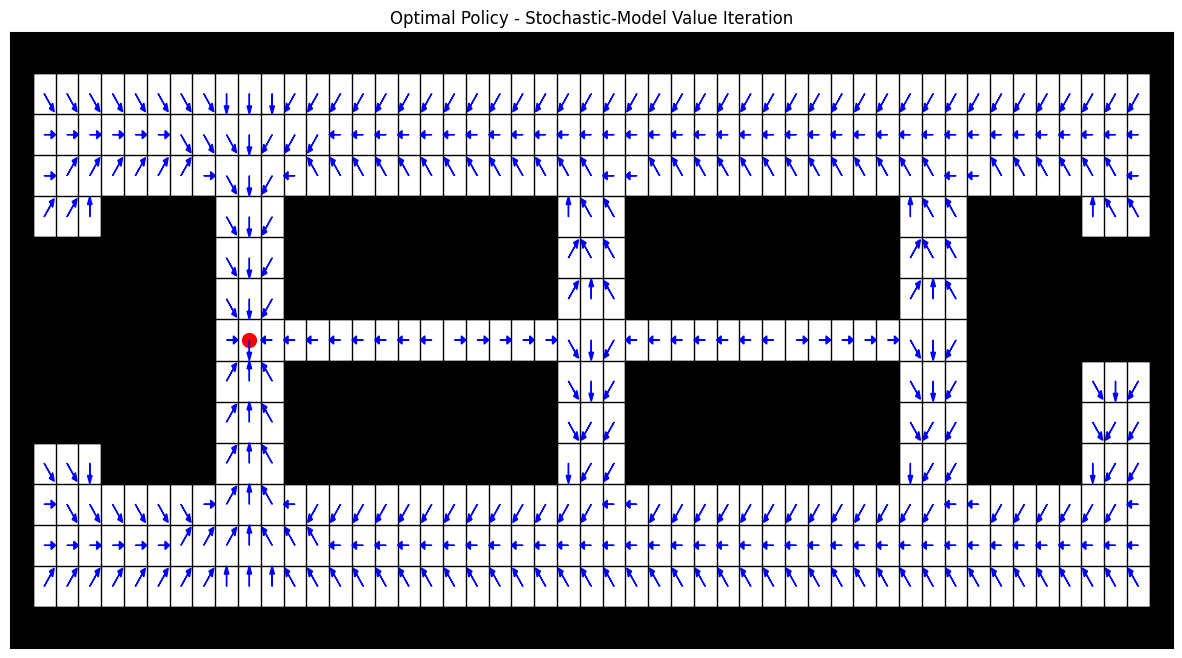

In [203]:
# perform value iteration for the stochastic model
policy, value = agent.ValueIter()
agent.PolicyGraph(policy, "Optimal Policy - Stochastic-Model Value Iteration")

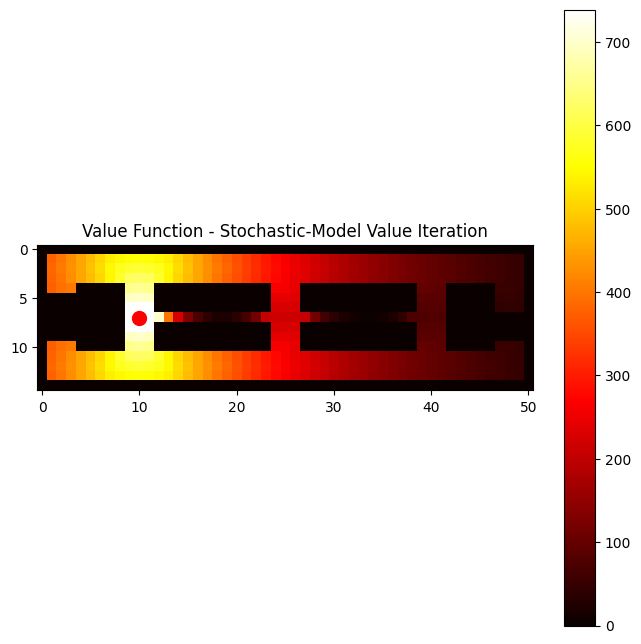

In [204]:
agent.ValueGraph(value, "Value Function - Stochastic-Model Value Iteration")